# 実験 II 補助資料

岡田 真

# PyTorch チュートリアル Cifer-10 を畳み込みニューラルネットワーク (Convolutional Neural Network, CNN) を使ったモデルで学習して画像のクラスを分類する．

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision データセット  
https://pytorch.org/docs/stable/torchvision/datasets.html

Cifer-10  
https://pytorch.org/docs/stable/torchvision/datasets.html#cifer

PyTorch にはさまざまなデータセットが用意されている．  
ここでは CIFER-10 のデータセットを読み込む．

transforms.Compose でデータをロードした後に適応する関数を作る．  
最初の ToTensor() でテンソルにする．次の Normalize で一般化する．最初のタプルが各チャンネルの平均値，後ろのタプルが標準偏差．Cifer-10 は RGB の 3 チャンネルなのでどちらも要素 3 個．

後ろで訓練用とテスト用にそれぞれデータを読み込んでからバッチ処理用に読み込めるように DataLoader に設定する．

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Dataloader を使ってデータセットを読み込む
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
# クラス
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

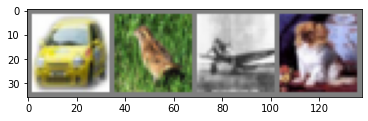

  car  bird plane   dog


In [4]:
# チェック用に画像を表示
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

CNN は畳み込み層とプーリング層で構成される．

畳み込み層は入力されるデータ（画像など）を先頭から走査していく．その際に決まったサイズ（2x2 ピクセルなど）のフィルタをかけて，圧縮（畳み込み）をしていく．だから畳み込みをすると全体の大きさは小さくなる．

プーリング層ではサンプリングをしてさらに圧縮する．畳み込んだ後の層の各画素を小さい区画（2x2など）に分割し，その中で決まった基準（最大値，平均値）の値を得て，その区画 (2x2 など) を 1 ピクセルに圧縮する．

torch.nn.Conv2d は 2 次元の畳み込み層．パラメータは入力チャンネル数，出力チャンネル数，フィルタサイズ．下の例は Cifer-10 を扱うので，入力は RGB の各層なので 3 チャンネル，出力チャンネル数はフィルタ数にあたって，モデル作成者の自由．ここでは 6 チャンネル（つまり 6 個フィルタが学習される），フィルタのサイズが 5 （つまり 5x5 画素ごとにフィルタをかける）．

torch.nn.MaxPool2d は 2 次元のプーリング層．パラメータはカーネルサイズとストライド．カーネルサイズは窓のサイズ（カーネルサイズxカーネルサイズの画素を対象とする），ストライドはずらす幅（2 なら 1 回の処理が終わったら 2 画素分動かす）．ここでは 2x2 の窓（カーネル）で一度に 2 画素ずつずらすようになっている．

上で見たように Cifer-10 の一つの画像は 32x32．

下の conv1 だとサイズ 5 のフィルタをかけてストライドはデフォルトの 1 なので 32 - 5 + 1 = 28 なので 28x28 の大きさの画像になる．

そのあとプーリング層を挟む．2x2 で圧縮してストライドは 2 なので 14x14 になる．

conv2 だと 14x14 でサイズ 5 のフィルタなので， 14-5+1=10 になる．

もう一度プーリング層を挟んで 2x2 でストライドは 2 だから 5x5 になる．

最終的に 16 チャンネルで 5x5 の画像が並ぶ．
それを線形層に入れたいので，線形層の入力サイズは 16x5x5 となる．

線形層の最後 fc3 の出力はクラス数になるので 10 となる．

In [5]:
# 画像のサイズチェック
images[0].size() # 3 チャンネル(RGB)，縦 32, 横 32

torch.Size([3, 32, 32])

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
# 画像データのサイズの変化
print("Input (Original size): ", images.size())
x = net.conv1(images)
print("CNN 1: ", x.size())
x = net.pool(x)
print("Pooling: ", x.size())
x = net.conv2(x)
print("CNN 2: ", x.size())
x = net.pool(x)
print("Pooling: ", x.size())
x = x.view(-1, 16*5*5) # 線形層 fc1 に合わせる．
print("Linear1:", x.size())
x = net.fc1(x)
print("Linear2:", x.size())
x = net.fc2(x)
print("Linear3:", x.size())
x = net.fc3(x)
print("Output:", x.size())

Input (Original size):  torch.Size([4, 3, 32, 32])
CNN 1:  torch.Size([4, 6, 28, 28])
Pooling:  torch.Size([4, 6, 14, 14])
CNN 2:  torch.Size([4, 16, 10, 10])
Pooling:  torch.Size([4, 16, 5, 5])
Linear1: torch.Size([4, 400])
Linear2: torch.Size([4, 120])
Linear3: torch.Size([4, 84])
Output: torch.Size([4, 10])


In [9]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.213
[1,  4000] loss: 1.854
[1,  6000] loss: 1.670
[1,  8000] loss: 1.590
[1, 10000] loss: 1.522
[1, 12000] loss: 1.486
[2,  2000] loss: 1.409
[2,  4000] loss: 1.387
[2,  6000] loss: 1.375
[2,  8000] loss: 1.340
[2, 10000] loss: 1.335
[2, 12000] loss: 1.318
Finished Training


In [10]:
# モデルの保存

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

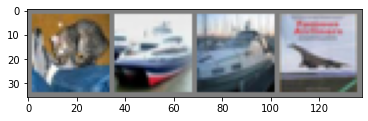

GroundTruth:    cat  ship  ship plane


In [11]:
# テスト実行
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [12]:
# モデル読み込み
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [13]:
# 出力結果をチェック
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship   car plane


In [14]:
# データセット全体での精度をチェック

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 53 %
Accuracy of   car : 56 %
Accuracy of  bird : 19 %
Accuracy of   cat : 22 %
Accuracy of  deer : 56 %
Accuracy of   dog : 51 %
Accuracy of  frog : 70 %
Accuracy of horse : 63 %
Accuracy of  ship : 62 %
Accuracy of truck : 70 %


この後，何を何と間違えて判定しているかチェックして confusion matrix を作ったり，  
エポック数やパラメータ調整で精度向上を図ったりする．

または，すでに学習されているモデルを読み込んで，それを転移学習したりする．

# MNIST を読み込んで動かしてみる．

In [16]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision データセット  
https://pytorch.org/docs/stable/torchvision/datasets.html

MNIST  
https://pytorch.org/docs/stable/torchvision/datasets.html#mnist

transforms.Compose でデータをロードした後に適応する関数を作る．  
最初の ToTensor() でテンソルにする．次の Normalize で一般化する．最初のタプルが各チャンネルの平均値，後ろのタプルが標準偏差．MNIST は 1 チャンネルなのでどちらも要素 1 個．

In [17]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

# Dataloader を使ってデータセットを読み込む
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [18]:
# クラス
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

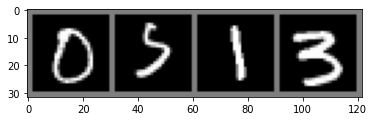

    0     5     1     3


In [19]:
# チェック用に画像を表示
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [20]:
# 画像のサイズチェック
images[0].size() # 1 チャンネル(RGB)，縦 28, 横 28

torch.Size([1, 28, 28])

モデルを作る．

最初の conv1 の入力チャンネルを 1 に変更．  
MNIST が 28x28 なので fc1 を 16 * 4 * 4 に変更．それに伴って forward も変更．

In [21]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [22]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [23]:
# 画像データのサイズの変化
print("Input (Original size): ", images.size())
x = net.conv1(images)
print("CNN 1: ", x.size())
x = net.pool(x)
print("Pooling: ", x.size())
x = net.conv2(x)
print("CNN 2: ", x.size())
x = net.pool(x)
print("Pooling: ", x.size())
x = x.view(-1, 16*4*4) # 線形層 fc1 に合わせる．
print("Linear1:", x.size())
x = net.fc1(x)
print("Linear2:", x.size())
x = net.fc2(x)
print("Linear3:", x.size())
x = net.fc3(x)
print("Output:", x.size())

Input (Original size):  torch.Size([4, 1, 28, 28])
CNN 1:  torch.Size([4, 6, 24, 24])
Pooling:  torch.Size([4, 6, 12, 12])
CNN 2:  torch.Size([4, 16, 8, 8])
Pooling:  torch.Size([4, 16, 4, 4])
Linear1: torch.Size([4, 256])
Linear2: torch.Size([4, 120])
Linear3: torch.Size([4, 84])
Output: torch.Size([4, 10])


In [24]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.100
[1,  4000] loss: 0.209
[1,  6000] loss: 0.147
[1,  8000] loss: 0.115
[1, 10000] loss: 0.095
[1, 12000] loss: 0.087
[1, 14000] loss: 0.067
[2,  2000] loss: 0.063
[2,  4000] loss: 0.069
[2,  6000] loss: 0.057
[2,  8000] loss: 0.061
[2, 10000] loss: 0.055
[2, 12000] loss: 0.049
[2, 14000] loss: 0.049
Finished Training


In [25]:
# モデルの保存 PyTorch Tutorial にあったから書いてる．Colab だと無理かも．

PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)

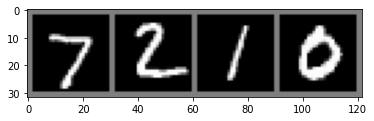

GroundTruth:      7     2     1     0


In [26]:
# テスト実行
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [27]:
# モデル読み込み PyTorch Tutorial にあったから書いてる．Colab だとうごかないかも
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [28]:
# 出力結果をチェック
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:      7     2     1     0


In [29]:
# データセット全体での精度をチェック

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 98 %


In [30]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 99 %
Accuracy of     5 : 97 %
Accuracy of     6 : 99 %
Accuracy of     7 : 98 %
Accuracy of     8 : 98 %
Accuracy of     9 : 96 %
